In [2]:
# these lines install modules cleantext and emoji. 
# Module cleantext is used to clean text data including: conversion of texts to lower case, removing unecessary panctuation and removal of stopwords.
# module emoji is needed to remove emocations from text.
!pip install cleantext
!pip install emoji==1.7
!pip install wget 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 669.8 kB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=ce4608aca34d740d30481a3cd7d55996ce0b054a5c54812d4654a13d04b4d220
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji
  Attempting uninstall: emoji
    Found existing installation: emoji 2.1.0
    Uninstalling emoji-2.1.0:
      Successfully uninstalled emoji-2.1.0
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=9496b26caa5438d046cde655d9256ab87658a002298674698f03c93a7c57a0e2
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [3]:
# here are all the modules used during this analysis. 
# you can use help() to get documentation of each, eg help('pandas') will give you documentation of pandas

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import cleantext 
import emoji 
import tensorflow as tf
from tensorflow.keras import datasets, layers, models,Input,Model
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, Conv2D, BatchNormalization, MaxPooling2D, Flatten, LSTM, Dense, Lambda, Dropout,Reshape,GlobalAveragePooling1D
import re
import keras
import shutil
import string
import random
import requests
from sklearn.cluster import KMeans
from sklearn import metrics
import wget
import zipfile
import os
from sklearn.metrics import (confusion_matrix,accuracy_score)
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import GridSearchCV
from functools import reduce
from sklearn.tree import DecisionTreeClassifier as DR
from sklearn.ensemble import GradientBoostingClassifier as GBoost

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from wordcloud import WordCloud,STOPWORDS, ImageColorGenerator
import pickle

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
# some parameters to be used
# some of this were relevantduring code creation
batch_size=64  #  Batch sizes to use
epoch =100       # number of training ephochs
sequence_length = 250   # here we can set arguments for text vectorization      
max_tokens=1000

 # Experimental setting
 
 This study makes use of a secondary data with details of **12,999 posts** retrieved from **244 websites** using webhose.io (RISDAL, 2016). The posts are labeled according B.S. detector software which is a web browser extension which scans links on a webpages and matches them to a professionally hand curated list of unreliable or sources. The extension labels unreliable sources with one of the following labels:
 
- **Fake News:** Sources that fabricate stories out of whole cloth with the intent of pranking the public.

- **Satire:** Sources that provide humorous commentary on current events in the form of fake news.

- **Extreme Bias:** Sources that traffic in political propaganda and gross distortions of fact.

- **Conspiracy Theory:** Sources that are well-known promoters of kooky conspiracy theories.

- **Rumor Mill:** Sources that traffic in rumors, innuendo, and unverified claims.

- **State News:** Sources in repressive states operating under government sanction.

- **Junk Science:** Sources that promote pseudoscience, metaphysics, naturalistic fallacies, and other scientifically dubious claims.

- **Hate Group:** Sources that actively promote racism, misogyny, homophobia, and other forms of discrimination.

- **Clickbait:** Sources that are aimed at generating online advertising revenue and rely on sensationalist headlines or eye-catching pictures.

- **Proceed With Caution:** Sources that may be reliable but whose contents require further verification.
 
In addition a label **“bs”** was added to the unlabeled. These are simply articles not flagged as questionable by B.S. Detector. The data is available on the link: https://www.kaggle.com/datasets/mrisdal/fake-news.

In [5]:
data= pd.read_csv("../input/fake-news/fake.csv")
#data=data.sample(n=1000)
data['Index']=range(0,data.shape[0])
data=data.set_index('Index')

Although Bs detector does extra work to specify which category of fake news an article belongs to, in this study we are only intrested in binary classfication i.e classifying an article as fake or reliable. the labels will therefore be coded to those 2 categories.

In [6]:
def to_binary_labels(labels):
    if labels =="bs":
        x="reliable"
    else:
        x="fake" 
    return x

data['label']=pd.Series (list(map(to_binary_labels,data['type'])))

The bar graphs below shows the distribution of articles before the above transformation and after the transformation.  out of the 12999 articles, 11492 of them are reliable news article while  1507 are fake news areticles. The bargraph on the left panel shows breakdowns of fake news category into more subcategories.

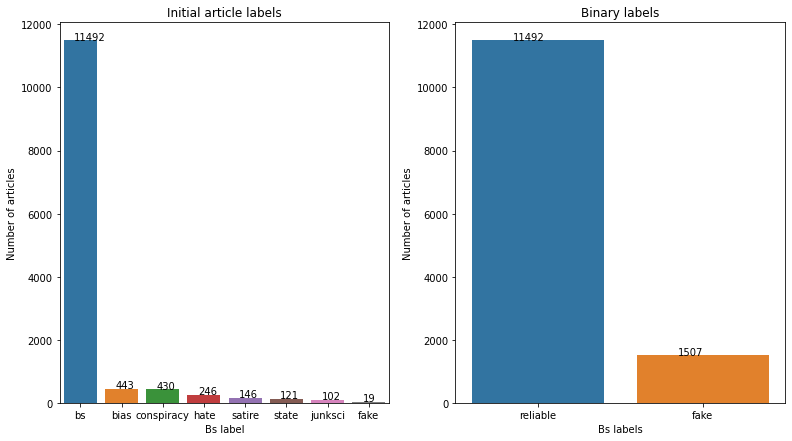

In [7]:
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(13,7))
sns.countplot(x='type',data=data,ax=ax[0],order=data.groupby('type').size().sort_values().index[::-1])
for p, label in zip(ax[0].patches, data['type'].value_counts().index):
    ax[0].annotate(p.get_height(), (p.get_x()+0.25, p.get_height()+20))
    ax[0].set_xlabel("Bs label")
    ax[0].set_ylabel("Number of articles")
    ax[0].set_title('Initial article labels')
    
sns.countplot(x='label',data=data,ax=ax[1],order=data.groupby('label').size().sort_values().index[::-1])
for p, label in zip(ax[1].patches, data['label'].value_counts().index):
    ax[1].annotate(p.get_height(), (p.get_x()+0.25, p.get_height()+20))
    ax[1].set_xlabel("Bs labels")
    ax[1].set_ylabel("Number of articles")
    ax[1].set_title('Binary labels')
    
plt.savefig('samp.png')

On the data the article title is contained on a seperate column with the article itself. so here we combine the two so that they can be analyzed together.

In [8]:
text1=[]
for i in range(data.shape[0]):
    if pd.isnull(data['title'][i]) or pd.isna(data['title'][i]):
        if pd.isnull(data['text'][i]) or pd.isna(data['text'][i]):
            x=""
        else:
            x=str(data['text'][i])
    else: 
        if pd.isnull(data['text'][i]) or pd.isna(data['text'][i]):
            x=str(data['title'][i])
        else:
            x=str(data['title'][i])+"\n"+str(data['text'][i])
    text1.append(x)
data['text1']=pd.Series (text1)

# Cleaning and  preprocessing articles

**_The collected articles will be processed using NLP to do away with stray characters, stopwords and unnecessary numerical values. This will be preceded by Tokenization which will be done using python Gensim module to convert the articles into word and sentence tokens. Lastly text vectorization (word embedment) will be done to convert the articles from string sequences to text sequences which can be used with machine learning algorithms.  Common word vectorization methods include one hot encoding, words and construction of Term frequency –Inverse document frequency matrix (TF-IDF) and training of word embedding’s using deep learning. In this study. Keras Word embedding model can be used to map words from the articles into a dense vector space (Li & Gong, 2021). This approach will be used to ensure similarity between words is preserved as the words are the words are converted into numerical vector representation. The final step will be to categorize 80% of the data into training and 20% of the data into evaluations set._** 

here several processing steps were undertaken to ensure that the data is clean before analysis.

## remove emojis
The articles consists emojis's which get encoded as bad characters, the lines below removes all the emoji and emocations from the articles

In [9]:
# remove emojis
def remove_emoji(string):
    return emoji.get_emoji_regexp().sub(u'', string)
data['text1']=data['text1'].apply(remove_emoji)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 'emoji.get_emoji_regexp()' is deprecated and will be removed in version 2.0.0. If you want to remove emoji from a string, consider the method emoji.replace_emoji(str, replace='').
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  This is separate from the ipykernel package so we can avoid doing imports until


There are characters which are easily used in Keyboards as alteranatives to panctuations, These gets encoded as unicodes which is not what we want. for example `ʺ`and `ʼ` are frequently confused with `"` and `'` although they look the same they are not encoded the same. Here is a full list of such characters:

https://lhncbc.nlm.nih.gov/LSG/Projects/lvg/current/docs/designDoc/UDF/unicode/DefaultTables/symbolTable.html


The lines below use this table to look up for such characters and replace them.

In [10]:
# here we are getting the table to python in order to do the replacement.

strange=pd.read_html(requests.get('https://lhncbc.nlm.nih.gov/LSG/Projects/lvg/current/docs/designDoc/UDF/unicode/DefaultTables/symbolTable.html').content)[-1] #getting the webpage with the table

strange=strange.append(pd.DataFrame({'Unicode':["U+302D"],      #  cast the table into a dataframe
              'Mapped String':["..."],
              "Char":["…"],
              'Unicode Name':["THREE DOTS"]}),ignore_index=True) 
s_n=len(strange)
strange=strange.drop(list(strange["Mapped String"]).index("'"))

In [11]:
# replacement was done here.
# the lines below iterates over each article , looking for the characters and replacing them.

for j in range(data.shape[0]):
    for i in [x for x in range(s_n) if x != 2]:
        data["text1"][j]=data["text1"][j].replace(strange["Char"][i],str(strange["Mapped String"][i]))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Taking a look on the first article after replacement

In [12]:
print(data["text1"][1])

Re: Why Did Attorney General Loretta Lynch Plead The Fifth?
Why Did Attorney General Loretta Lynch Plead The Fifth? Barracuda Brigade 2016-10-28 Print The administration is blocking congressional probe into cash payments to Iran. Of course she needs to plead the 5th. She either can't recall, refuses to answer, or just plain deflects the question. Straight up corruption at its finest! 
100percentfedUp.com ; Talk about covering your ass! Loretta Lynch did just that when she plead the Fifth to avoid incriminating herself over payments to Iran...Corrupt to the core! Attorney General Loretta Lynch is declining to comply with an investigation by leading members of Congress about the Obama administration's secret efforts to send Iran $1.7 billion in cash earlier this year, prompting accusations that Lynch has "pleaded the Fifth" Amendment to avoid incriminating herself over these payments, according to lawmakers and communications exclusively obtained by the Washington Free Beacon. 
Sen. Marc

# more cleaning
On the next column we removed extra white space and converted words to lowercase.

In [13]:
def my_clean(text):
    try:
        x=cleantext.clean(text,clean_all= False, # Execute all cleaning operations
                           extra_spaces=True ,  # Remove extra white spaces 
                           stemming=False , # Stem the words
                           stopwords=False ,# Remove stop words
                           lowercase=True ,# Convert to lowercase
                           numbers=False ,# Remove all digits 
                           punct=False ,# Remove all punctuations
                           reg= "", # Remove parts of text based on regex
                           reg_replace='', # String to replace the regex used in reg
                           stp_lang='english')  # Language for stop words
    except BaseException as e:
        x=""
    return x
data['article']=data['text1'].apply(my_clean) 

In [14]:

def my_clean1(text): 
    try:
        x=cleantext.clean(text,clean_all= False, # Execute all cleaning operations
                           extra_spaces=True ,  # Remove extra white spaces 
                           stemming=True , # Stem the words
                           stopwords=True ,# Remove stop words
                           lowercase=True ,# Convert to lowercase
                           numbers=True ,# Remove all digits 
                           punct=True ,# Remove all punctuations
                           reg= '\n', # Remove parts of text based on regex
                           reg_replace='', # String to replace the regex used in reg
                           stp_lang='english')  # Language for stop words
    except BaseException as e:
        x=""
    return x
texts=data['article'].apply(my_clean1)

In [15]:
leb=pd.get_dummies(data['label']).values  # convert labels to dummies
print(leb[0],data['label'][0])            # print label for the first article to see how it looks like

[1 0] fake


## summary statistics and visualization

before diving into the main  analysis, I first looked at some summary statistics for theses articles. first my major concern was sentiment score and spam score. with sentiment score here i would want to understand whether there is relationship between the choice of words and whether message is fake or reliable, i.e does fake news consist more of negative talk or vice versa. 

# calculating sentiment score.

To get my sentiment scores I used sentment analyzer  The sentiment lexicon in VADER is a list of lexical features like words and phrases labeled as positive or negative according to their semantic orientation. so for each article a score is computed by summing individual word sentiments 


Here I select columns to use.

In [16]:
dat=data[['uuid','language','country', 'spam_score', 'replies_count',
       'participants_count', 'likes', 'comments', 'shares','label']]
dat['article']=texts 
dat['article'] = dat['article'].str.replace("[^a-zA-Z#]", " ")
dat['uuid']=range(dat.shape[0])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing

Here I created an empty pandas dataframe to save the sentiment scores

In [17]:
dat1=pd.DataFrame()
dat1['uuid']=['99999999999']
dat1['type']='NA999NA'
dat1['sentiment_score']=0

Iterate over the articles, calculate the sentiment score and save them to our data.

In [18]:
sid = SentimentIntensityAnalyzer()

dat2 = dat1
for index, row in dat.iterrows():
    scores = sid.polarity_scores(row[10])
    for key, value in scores.items():
        temp = [key,value,row[0]]
        dat1['uuid']=row[0]
        dat1['type']=key
        dat1['sentiment_score']=value
        dat2=dat2.append(dat1)
dat3 = dat2[dat2.uuid != '99999999999']
dat3 = dat3.drop_duplicates()
dat3 = dat2[dat2.type == 'compound']
dat=pd.merge(dat,dat3, on='uuid', how='inner')

Here are summary statistics for both sentiment and spamm score. looking at the mean and median we can see they are too close for both fake and reliable cases. this tell us. the languge used in publishing reliable and fake news doesnt differ too much.

In [19]:
with open("dat.pkl","wb") as file:
    pickle.dump(dat,file)

In [20]:
dat[['spam_score','sentiment_score','label']].groupby('label').agg(['count','min','max','mean','std','median'], axis=1)

spam_score                                      sentiment_score  \
              count  min  max      mean       std median           count   
label                                                                      
fake           1507  0.0  1.0  0.019633  0.106925    0.0            1507   
reliable      11492  0.0  1.0  0.026973  0.124810    0.0           11492   

                                                     
             min     max      mean       std median  
label                                                
fake     -0.9999  0.9997 -0.008369  0.783038    0.0  
reliable -1.0000  0.9999 -0.008892  0.806569    0.0

In [21]:
mel=pd.melt(dat[['spam_score','sentiment_score','label']],id_vars='label',var_name='metrics', value_name='values')

Here I graphed overlayed density plots.They as well show no big difference in sentiment /spam scores across fake and reliable articles

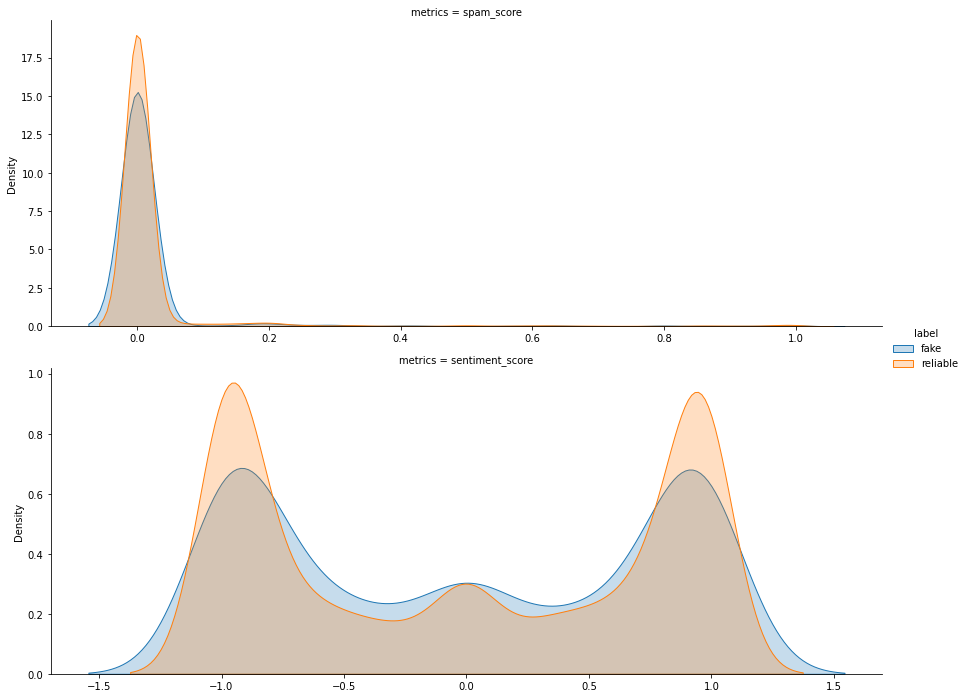

In [22]:

g=sns.FacetGrid(mel, col="metrics",hue='label',
                col_wrap=1,
                sharex=False,sharey=False,
                #xlim=(0,1),
                height=5, aspect=2.5,
                legend_out=True)
g.map(sns.kdeplot,'values',fill=True)
g.set_xlabels("")
g.add_legend()
plt.savefig('density.png')

Next I did wordplots showing most common words in both groups(fake and reliable)

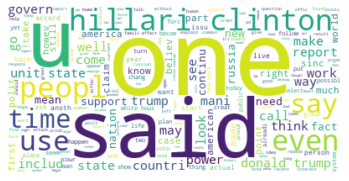

<Figure size 432x288 with 0 Axes>

In [23]:
text = " ".join(review for review in dat[dat['label']=='reliable'].article)
wordcloud = WordCloud(background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
plt.savefig('worldcloud1.png')

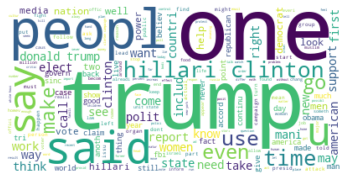

<Figure size 432x288 with 0 Axes>

In [24]:
text = " ".join(review for review in dat[dat['label']=='fake'].article)
wordcloud = WordCloud(background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
plt.savefig('worldcloud2.png')

Next the labels were converted into two class dummy variables because neural networks won't allow character strings.This means because we have two classes, in this order fake,reliable. label `[1 0]` would mean fake while `[0 1]` would mean reliable. Here is a example using the first row.

# Train test, validation splits

The data was then split into 80% training set, 15% testing and 5% validation sets. The training  set, will be used to train the model, testing will be used to test the model while  validation will be used for validation purposes.

In [25]:
random.seed(100)                                                    # set a random seed to be able to replicate sampling
train_ind=random.sample(range(len(data)), k=round(len(data) * 0.8)) # sample 80% of the articles, This gives the indeces for rows/articles  to use for training
test_valid_ind=list(set(range(len(data))).difference(train_ind))    # the remaining 20% of the rows will be used for testing and validation
random.seed(100) 
test_ind=random.sample(test_valid_ind,k=round(len(test_valid_ind) * 0.75))# again frm the 20% for training/testing 75% of it goes to testing here we got the row indices
valid_ind=list(set(test_valid_ind).difference(test_ind))                  # the remaining 25% will be used for validation 

train=data.iloc[train_ind,]                         # subsetting the train articles
test=data.iloc[test_ind,]                           # subsetting the test articles
valid=data.iloc[valid_ind,]                         #subsetting the validation articles

In [26]:
print("---------training breakdown-----------")
print()
print(train.label.value_counts())
print()
print("---------testing breakdown-----------")
print()
print(test.label.value_counts())
print()
print("---------validation breakdown-------")
print(valid.label.value_counts())

---------training breakdown-----------

reliable    9194
fake        1205
Name: label, dtype: int64

---------testing breakdown-----------

reliable    1720
fake         230
Name: label, dtype: int64

---------validation breakdown-------
reliable    578
fake         72
Name: label, dtype: int64


Tensorflow is one useful data pipeline which we easily use to build machine learning and deep learning models. it has features such as data batching, catching, prefetching among other features which support overlapping of data processing and model fitting to  makes model development more faster: Here is a more explanation about the API.
https://www.tensorflow.org/about/. 

On the cell below,I converted the data into tensorflow dataset to take advantage of these features.

In [27]:
train = tf.data.Dataset.from_tensor_slices((list(train["article"]),list(leb[train_ind]))) # convert train data to tf.data.Dataset
test = tf.data.Dataset.from_tensor_slices((list(test["article"]),list(leb[test_ind])))    # convert test data to tf.data.Dataset
valid = tf.data.Dataset.from_tensor_slices((list(valid["article"]),list(leb[valid_ind]))) # convert valid data to tf.data.Dataset

2022-11-23 08:42:57.971307: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-23 08:42:58.100371: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-23 08:42:58.101193: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-23 08:42:58.103762: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

The dataset was batched into batches of 64 articles to enable faster processing and model fitting. batching is among performance configurations which help improve model building speed and effecioence. Here is a more comprehesive explanation, about data batching.
https://stackoverflow.com/questions/41175401/what-is-a-batch-in-tensorflow

Here are more performance configurations: https://www.tensorflow.org/guide/data_performance

In [28]:
train= train.batch(batch_size=batch_size)  # batch train data into batches of size 64 
test= test.batch(batch_size=batch_size)    # batch train data into batches of size 64
valid= valid.batch(batch_size=batch_size)  # batch train data into batches of size 64

In [29]:
tf.data.experimental.save(train, "train")
tf.data.experimental.save(test, "train")
tf.data.experimental.save(valid, "valid")

2022-11-23 08:43:01.107713: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [30]:
print("training batches :",len(train))
print("test batches :",len(test))
print("valid batches :",len(valid))

training batches : 163
test batches : 31
valid batches : 11


Inorder to extract features from text data inform of Keras embeddings, text vectorization need to be first done. This involves conversion of words into numeric representation. The code on the next cell is a function to vectorize texts. Given a text the function converts them into vectors of integers.

Here is a documentation for text vectorization layer: https://keras.io/api/layers/preprocessing_layers/core_preprocessing_layers/text_vectorization/

In [31]:
vectorize_layer = layers.TextVectorization(
    max_tokens=max_tokens,
    pad_to_max_tokens=True,
    output_mode='int')

train_article = train.map(lambda x, y: x)
vectorize_layer.adapt(train_article)

The function on the next cell applies the  above text vectorizer function given a datasets with articles.

In [32]:
def vectorize_articles(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

Here is a demonstration on how to use this function.It shows how the first article can be vectorized, into integers.

In [33]:
article,label= next(iter(train))
sample_article,sample_label = article[1],label[1]
print("Article:")
print(sample_article)
lb=["Reliable","Fake"]
print("Label:")
print(sample_label)
print("After vectorization:")
print(vectorize_articles(sample_article,sample_label))

Article:
tf.Tensor(b"uci picks iran outfit as best cycling team in asia\nsports this file photo shows members of the national iranian men's cycling team. \nthe union cycliste internationale (uci) has named the national iranian men's cycling team as the greatest team in asia, thanks to its outstanding performances at continental sports events. \naccording to the latest monthly rankings released by the world's governing body for sports cycling and international competitive cycling events, the iranian side collected 1,587 points to claim the top position among other asian outfits. \nkazakhstan landed in the second asian slot of the uci rankings with 1,451 points, followed by japan and south korea, which claimed the third and fourth spots respectively with 884 and 718 points. \nadditionally, the iranian cycling club, pishgaman kavir yazd, accumulated 915 points to stand out in the continental ranking. \nit was followed by another iranian squad, tabriz shahrdari team, with 884 points in the

Here yare all vocabularies I named them vocabularies, I al
Here we can get any number on the vectorized text and decode what number it represents.

In [39]:
vocabularies = vectorize_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [37]:
print("2 ---> ",vectorize_layer.get_vocabulary()[2])

2 --->  the


In [ ]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

Caching and prefetching were configured for all the 3 datasets to ensure overlap between data processing activities. These are actually among performance configurations on the link previously provided.

In [35]:
AUTOTUNE = tf.data.AUTOTUNE 
train = train.map(vectorize_articles).cache().prefetch(buffer_size=AUTOTUNE)  # set catching and prefetching on training data
valid = valid.map(vectorize_articles).cache().prefetch(buffer_size=AUTOTUNE)  #set catching and prefetching on testing data
test = test.map(vectorize_articles).cache().prefetch(buffer_size=AUTOTUNE)    #  set catching and prefetching on validation data

We will need these 3 dataset later so here we will have to save them under a different name

In [36]:
train1=train
test1=test
valid1=valid


The overall approach features both an ANN classifier and Kmeans clustering as we presented in chapter 3. Here is a visual representation of it.

![image.png](attachment:dc590e8f-5189-44ed-8791-d381224e9cde.png)

**ANN**

**_A feed forward artificial neural network (ANN) will be used to learn sequences of the vectorized words from the word embedding, to classify articles as reliable or unreliable. This analysis will be implemented in python Keras modules. Keras Tuner module will be used to try different values for hyper parameters in search of the best performing mixture._**
 
 
 The model was developed with the following layers types.
 
 - Input layer- to receive articles and send them to the hidden layers
 
 - Hidden layers - the intermidiate layers which  includes embedding layer and 2 bidirectional layers used to do feature extraction , and dense layers which perform classification.  
 
- Output layers - this outputs the predictions from the dense layer. 


Here is the documentation of different Keras layers and how to use them: https://keras.io/api/layers/

More information about layers we used.
- Sequential model  : https://keras.io/guides/sequential_model/
- Input layers: https://keras.io/api/layers/core_layers/input/
- Text embeddings: https://keras.io/api/layers/core_layers/embedding/
- Dense layers:https://keras.io/api/layers/core_layers/dense/
- Bidirectional layers: https://keras.io/api/layers/recurrent_layers/bidirectional/
- Drop out layers: https://keras.io/api/layers/regularization_layers/dropout/
- Batch normalization: https://keras.io/api/layers/normalization_layers/batch_normalization/

In [77]:

embedding_dim=16
model=Sequential(name="my_model")
model.add(Input(shape=(None,), dtype="int32",name="input_articles"))
model.add(Embedding(max_tokens + 1, embedding_dim,name="embeddinglayer"))
model.add(layers.Conv1D(16,5, activation='relu'))
model.add(Dropout(0.2,name="dropout"))
model.add(BatchNormalization(name="batchnormalization"))
#model.add(GlobalAveragePooling1D(name="avgpool"))
# flatten
#model.add(Flatten(name="flatten_layer"))
model.add(Bidirectional(LSTM(8, return_sequences=True),name="Bidirectional1"))
model.add(Bidirectional(LSTM(8),name="Bidirectional2"))
model.add(Dropout(0.2,name="dropout1"))
model.add(Dense(units=8,activation="relu"))
model.add(Dense(units=2, activation="softmax"))

In [83]:

embedding_dim=10
model=Sequential(name="my_model")
model.add(Input(shape=(None,), dtype="int32",name="input_articles"))
model.add(Embedding(max_tokens + 1, embedding_dim,name="embeddinglayer"))
model.add(Dropout(0.2,name="dropout"))
model.add(BatchNormalization(name="batchnormalization"))
model.add(Bidirectional(LSTM(8),name="Bidirectional2"))
model.add(Dropout(0.2,name="dropout1"))
model.add(Dense(units=8,activation="relu"))
model.add(Dense(units=2, activation="softmax"))

Here is a visualization of the layer arrangement. to see if we got the intented stacking

In [84]:
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embeddinglayer (Embedding)   (None, None, 16)          16016     
_________________________________________________________________
conv1d_10 (Conv1D)           (None, None, 16)          1296      
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
batchnormalization (BatchNor (None, None, 16)          64        
_________________________________________________________________
Bidirectional2 (Bidirectiona (None, 16)                1600      
_________________________________________________________________
dropout1 (Dropout)           (None, 16)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 136

The model was compiled with the following evaluation metrics; Accuracy, Sensitivity,specificity and precision

In [85]:
model.compile(                                              
  optimizer='adam',                                         # compile the model with adams optimizers
  loss="categorical_crossentropy",                          # use categorical cross entropy loss functions
  metrics=["accuracy",                                      # while fitting the model will be evaluated on the testing set using:- Accuracy
           tf.keras.metrics.Recall(name="Sensitivity",class_id=0),                                                              # - Sensitivity                                               
           tf.keras.metrics.Recall(name="Specificity",class_id=1),                                                              # - Specificity 
           tf.keras.metrics.Precision(name="Precision",class_id=0)])                                                            # - precision

In [ ]:
# here I sampled a few batches to use during code developmet rather than the whole data.
#train=train.take(n1)

The model was fitted on the training data and evaluated on the testing set

In [1]:
1001*16

16016

In [86]:
mod=model.fit(
 train,
  validation_data=test,
 epochs=50)

Epoch 1/50
163/163 [==============================] - 64s 375ms/step - loss: 0.4172 - accuracy: 0.8670 - Sensitivity: 0.0216 - Specificity: 0.9778 - Precision: 0.1130 - val_loss: 0.3900 - val_accuracy: 0.8821 - val_Sensitivity: 0.0000e+00 - val_Specificity: 1.0000 - val_Precision: 0.0000e+00
Epoch 2/50
163/163 [==============================] - 61s 371ms/step - loss: 0.3558 - accuracy: 0.8841 - Sensitivity: 0.0000e+00 - Specificity: 1.0000 - Precision: 0.0000e+00 - val_loss: 0.3680 - val_accuracy: 0.8821 - val_Sensitivity: 0.0000e+00 - val_Specificity: 1.0000 - val_Precision: 0.0000e+00
Epoch 3/50
163/163 [==============================] - 61s 373ms/step - loss: 0.3249 - accuracy: 0.8841 - Sensitivity: 0.0017 - Specificity: 0.9998 - Precision: 0.5000 - val_loss: 0.3387 - val_accuracy: 0.8821 - val_Sensitivity: 0.0000e+00 - val_Specificity: 1.0000 - val_Precision: 0.0000e+00
Epoch 4/50
163/163 [==============================] - 61s 375ms/step - loss: 0.2892 - accuracy: 0.8897 - Sensitiv

In [ ]:
model.save("model")

In [ ]:
mod

In [ ]:
with open("mod_hist.pkl","wb") as file:
    pickle.dump(mod.history,file)

The graph below visualizes model accuracy and loss on both training and testing sets. the larger difference between the two insiuates posibility of underfitting.

In [ ]:
#Accuracy
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,6))
ax[0].plot(mod.history['accuracy'])
ax[0].plot(mod.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'test'], loc='upper left')

# loss
ax[1].plot(mod.history['loss'])
ax[1].plot(mod.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'test'], loc='upper left')
plt.savefig('othercomparing1.png')

In [ ]:
# Accuracy
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,6))
ax[1].plot(mod.history['val_accuracy'])
ax[1].plot(mod.history['val_Sensitivity'])
ax[1].plot(mod.history['val_Specificity'])
#ax[1].plot(hist.history['val_Precision'])
#ax[1].plot(hist.history['val_f1_score'])
ax[1].set_title('Testing Set')
ax[1].set_ylabel('score')
ax[1].set_xlabel('epoch')
ax[1].legend(['accuracy','Sensitivity','Specificity','Precision','F1 score'], loc='upper left')

# Accuracy
ax[0].plot(mod.history['accuracy'])
ax[0].plot(mod.history['Sensitivity'])
ax[0].plot(mod.history['Specificity'])
#ax[0].plot(hist.history['Precision'])
#ax[0].plot(hist.history['f1_score'])
ax[0].set_title('Training Set')
ax[0].set_ylabel('score')
ax[0].set_xlabel('epoch')
ax[0].legend(['accuracy','Sensitivity','Specificity','Precision','F1 score'], loc='upper left')
plt.savefig('othercomparing2.png')

Next the model was evaluated on the testing set. To see how good the model can work on a data . I evaluated, the model on the testing set below, to see its performance.

In [ ]:
mod1=model.evaluate(test)[1:5]
mod1=pd.DataFrame({"Measure":['Accuracy','Sensitivity','Specificty','Precision'],
    "Original Dataset":[np.round(float(i), 4) for i in mod1]}) 
mod1

**Kmeans**
**_A Kmeans clustering approach will also be used to try and cluster the vectorized articles. The anticipated number of clusters is 2, each representing our outcome groups_**

First the features extracted from the text data during feature extraction step will be used. The cell below,gets these features

In [ ]:
# feature extraction model
feature_miner=Model(
    inputs=model.inputs,
    outputs=model.get_layer(name="Bidirectional2").output,name="feature_miner"
)
predictors=feature_miner.predict(train)

**fitting Kmeans**

- Here we fitted a k- means model using

In [ ]:
kmea=KMeans(n_clusters=2, random_state=0).fit(predictors)
tests=feature_miner.predict(test)
kmea.labels_

In [ ]:
with open("predictors.pkl","wb") as file:
    pickle.dump(predictors,file)
    
with open("tests.pkl","wb") as file:
    pickle.dump(tests,file)
    
with open("kmea.pkl","wb") as file:
    pickle.dump(kmea,file)

Since Kmeans is not a classifier, the articles new data(validation) were assigned into the cluster they are near to.

In [ ]:
kmeans_pred=kmea.predict(tests)

The code on the cell  below extracts the labels from the data.

In [ ]:
def labels(ds):
    labels=[]
    for batch in ds:
        articles,labelss=batch
        labelss=labelss.numpy()
        labels.append(labelss)
    labels=np.concatenate(labels)
    return labels

def two_cat_to_one(labels):
    lls=[]
    for label in labels:
        lls.append(label[0])
    return lls
label_train=np.array(two_cat_to_one(labels(train)))
label_test=np.array(two_cat_to_one(labels(test)))
label_valid=np.array(two_cat_to_one(labels(valid)))

An important thing to notice is,the Kmeans labels  0,1 represent clusters 0 and 1 but not the data labels 0,1. the code here tries to determine which category  exacltly matches which cluster.

In [ ]:
if np.mean(kmeans_pred==label_test)>=np.mean((1-kmeans_pred)==label_test):
    kmeans_pred=kmeans_pred
else:
    kmeans_pred=(1-kmeans_pred)

Evaluation on the clustering

In [ ]:
pd.DataFrame({'Measure':['Accuracy','Sensitivity','Specitivity','Precision','F1_score'],
             "Original Dataset":[metrics.accuracy_score(label_test,kmeans_pred),
                        metrics.recall_score(label_test, kmeans_pred,pos_label=0),
                        metrics.recall_score(label_test, kmeans_pred,pos_label=1),
                        metrics.precision_score(label_test,kmeans_pred,pos_label=0),
                        metrics.f1_score(label_test,kmeans_pred,pos_label=0)]})

Next was to weight between the predictions of clustering and those from model prediction. Here a user defined function was used, which compares sensitivity from the clustering predictions and those that of from the ANN. the the model with higher sensitivity will be used to predict the the fake news class. conversely the model with higher specificity predicts the other category.

In [ ]:
modelpred=model.predict(test)
modelpred1=[]
for pred in modelpred:
    modelpred1.append(round(pred[0]))

In [ ]:
def weighting(deepmodelpred,Kmeansmodelpred,truelabels):
    sensdeep=metrics.recall_score(truelabels,modelpred1,pos_label=0)
    specdeep=metrics.recall_score(truelabels,modelpred1,pos_label=1)
    senskmeans=metrics.recall_score(truelabels,Kmeansmodelpred,pos_label=0)
    speckmean=metrics.recall_score(truelabels,Kmeansmodelpred,pos_label=1)
    
    if sensdeep>=senskmeans and specdeep>=speckmean:
        pre=deepmodelpred
    elif sensdeep<senskmeans and specdeep<speckmean:
        pre=Kmeansmodelpred
    elif sensdeep>=senskmeans and specdeep<speckmean:
        pre=[]
        for i in range(len(deepmodelpred)):
            if deepmodelpred[i]==0:
                x=0
            else:
                x=Kmeansmodelpred[i]
            pre.append(x)
    else:
        pre=[]
        for i in range(len(Kmeansmodelpred)):
            if Kmeansmodelpred[i]==0:
                x=0
            else:
                x=deepmodelpred[i]
            pre.append(x)
    return pre

In [ ]:
preds=weighting(modelpred1,kmeans_pred,label_test)

In [ ]:
pd.DataFrame({'Measure':['Accuracy','Sensitivity','Specitivity','Precision','F1_score'],
             "Original Dataset":[metrics.accuracy_score(label_test,preds),
                        metrics.recall_score(label_test, preds,pos_label=0),
                        metrics.recall_score(label_test, preds,pos_label=1),
                        metrics.precision_score(label_test,preds,pos_label=0),
                        metrics.f1_score(label_test,preds,pos_label=0)]})

# Validation

In [ ]:
modelpred=model.predict(valid)
modelpred1=[]
for pred in modelpred:
    modelpred1.append(round(pred[0]))

In [ ]:
valids=feature_miner.predict(valid)
kmeans_pred=kmea.predict(valids)
if np.mean(kmeans_pred==label_valid)>=np.mean((1-kmeans_pred)==label_valid):
    kmeans_pred=kmeans_pred
else:
    kmeans_pred=(1-kmeans_pred) 
preds=weighting(modelpred1,kmeans_pred,label_valid)

In [ ]:
pd.DataFrame({'Measure':['Accuracy','Sensitivity','Specitivity','Precision','F1_score'],
             "Original Dataset":[metrics.accuracy_score(label_valid,preds),
                        metrics.recall_score(label_valid, preds,pos_label=0),
                        metrics.recall_score(label_valid, preds,pos_label=1),
                        metrics.precision_score(label_valid,preds,pos_label=0),
                        metrics.f1_score(label_valid,preds,pos_label=0)]})